## B. oleracea troubleshooting
https://hub.mybinder.org/user/danforthcenter-plantcv-binder-4b6sew5l/notebooks/notebooks/multi_plant_tutorial.ipynb

### Load required packages

In [ ]:
import numpy as np
from plantcv import plantcv as pcv
import cv2 
import os

### Define options
change input image here 

In [179]:
class options:
    def __init__(self):
        self.image = "../segmented_images/B_oleracea001_A_0_p0_mask.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "./troubleshooting_results"
        self.outdir = "./troubleshooting_results"
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

### Read in target image 

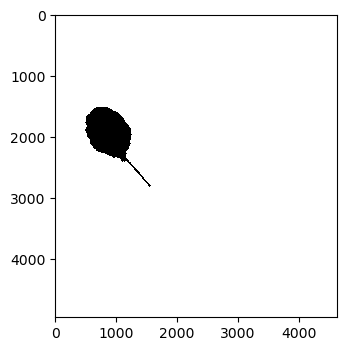

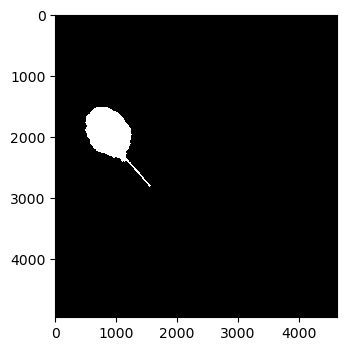

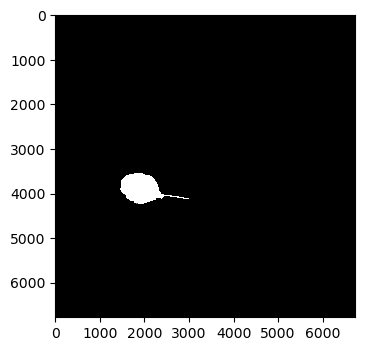

In [180]:
img1, path, filename = pcv.readimage(args.image)
img2 = pcv.invert(img1)
img2 = pcv.rotate(img2, 40, False)

### STEP 3: Convert from RGB colorspace to LAB colorspace
Keep green-magenta channel (a)  

Output is a grayscale image

inputs:
* img = image object, RGB colorspace
* channel = color subchannel ('l' = lightness, 'a' = green-magenta, 'b' = blue-yellow)

In [ ]:
a = pcv.rgb2gray_lab(img1, 'a')
b = pcv.rgb2gray_lab(img1, 'b') 
l = pcv.rgb2gray_lab(img1, 'l')
# select blue to yellow colorspace (try it out I guess?)

### STEP 4: Set a binary threshold on the saturation channel image
inputs:
* img = img object, grayscale
* threshold = treshold value (0-255) - need to adjust this
* max_value = value to apply above treshold (255 = white)
* object_type = light or dark

In [ ]:
# could use Otsu treshold, but doesn't seem to work as well 
# img_binary = pcv.threshold.otsu(masked2, 255, object_type = "dark")
# was using 118/120 
img_binarya = pcv.threshold.binary(a, 118, 255, object_type = "dark") # 118
img_binarya2 = pcv.threshold.binary(a, 128, 255, object_type = "light") # 128
img_binaryb = pcv.threshold.binary(b, 132, 255, object_type = "light") # 132

In [ ]:
# try using l channel
img_binaryl = pcv.threshold.binary(l, 140, 255, object_type = "dark")

In [ ]:
test = cv2.add(img_binarya, img_binarya2)
test = cv2.add(test, img_binaryb)
test = cv2.add(test, img_binaryl)

# test = img_binarya

test = cv2.add(img_binaryb, img_binaryl)

masked, binary, contours, hierarchy = pcv.rectangle_mask(test, (0, 2000), (1300, 4000), color = "black")
# masked, binary, contours, hierarchy = pcv.rectangle_mask(masked, (3025, 0), (3100, 4000))
# masked, binary, contours, hierarchy = pcv.rectangle_mask(masked, (0,0), (25,4000))
# 0,2000 1300,4000
# masked, binary, contours, hierarchy = pcv.rectangle_mask(masked, (3000, 0), (3100, 4000))
# masked2, binary, contours, hierarchy = pcv.rectangle_mask(masked, (0, 3600), (4000, 4000), color = "black")
# masked3, binary, contours, hierarchy = pcv.rectangle_mask(masked2, (0, 0), (4000, 40), color = "black")

### STEP 5: Apply Gaussian blur to binary image (reduces noise)
inputs:
* img = img object, binary
* ksize = tuple of kernel dimensions, e.g. (5,5)

In [ ]:
blur_image = pcv.median_blur(masked, (10, 10))

### STEP 6: Fill small objects (speckles)
inputs:
* img = img object, binary
* size = minimum object area size in pixels

In [ ]:
fill_image1 = pcv.fill(blur_image, 90000) #90000

### STEP 7: Invert image to fill gaps
inputs:
* img = img object, binary

Then rerun fill on inverted image to fill small gaps & re-invert

In [ ]:
inv_image = pcv.invert(fill_image1)

In [ ]:
inv_fill = pcv.fill(inv_image, 25000)

In [ ]:
fill_image = pcv.invert(inv_fill)

### STEP 8: Dilate to avoid losing detail
inputs:
* img = img object, binary
* ksize = kernel size
* i = iterations (number of consecutive filtering passes)

In [ ]:
dilated = pcv.dilate(fill_image, 2, 1)

In [ ]:
eroded = pcv.erode(dilated, 2, 1)

In [ ]:
obj_input = pcv.rotate(eroded, 40, False)

# remove petioles
https://stackoverflow.com/questions/42251910/opencv-leaf-petiole-removal

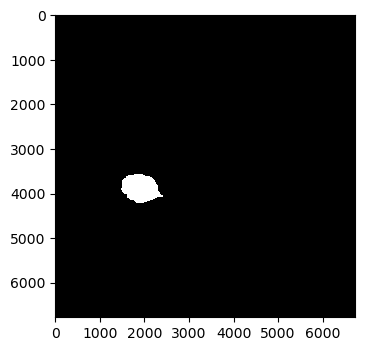

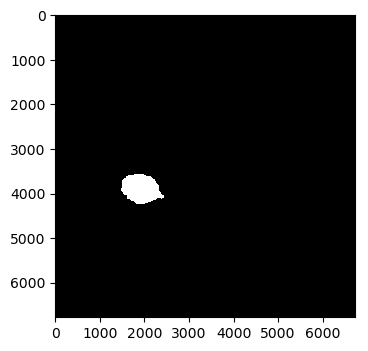

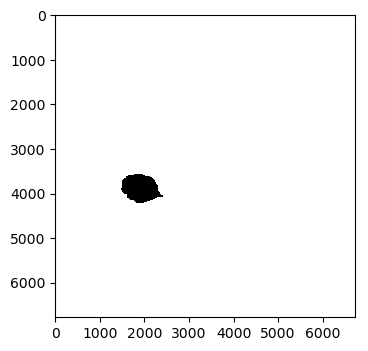

In [181]:
dist_transform = cv2.distanceTransform(img2, cv2.DIST_L2, 5)
ret, petiole = cv2.threshold(dist_transform, 0.06*dist_transform.max(), 255, 0)

petiole = np.uint8(petiole)

# pcv.invert(petiole)

petiole_removed = pcv.fill(petiole, 25000)


petiole_dilated = pcv.dilate(petiole_removed, 2, 20)


petiole_removed = pcv.invert(petiole_removed)

outdir = "troubleshooting_results/"

file = outdir + filename

# print(file)

# pcv.print_image(petiole_removed, file)



### STEP 9: Find objects (contours: black-white boundaries)
inputs:
* img = img object, RGB colorspace
* mask = binary image used for object detection

In [ ]:
# id_objects, obj_hierarchy = pcv.find_objects(img2, obj_input)
id_objects, obj_hierarchy = pcv.find_objects(img2, petiole_removed)

### STEP 10: Define region of interest (ROI)
inputs:
* img = img object to overlay ROI
* x_adj = adjust center along x axis
* y_adj = adjust center along y axis
* w_adj = adjust width
* h_adj = adjust height

In [ ]:
# roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img2, x=10, y=10, h=3400, w=3600)

roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img2, x=10, y=10, h=6000, w=6000)

### STEP 11: Keep objects that overlap with the ROI
inputs:
* img = img where selected objects will be displayed
* roi_type = options are 'cutto', 'partial' (objects are partially inside roi), or 'largest' (keep only the biggest boi)
* roi_countour = contour of roi, output from 'view and adjust roi' function (STEP 10)
* roi_hierarchy = contour of roi, output from 'view and adjust roi' function (STEP 10)
* object_contour = contours of objects, output from 'identifying objects' function (STEP 9)
* obj_hierarchy = hierarchy of objects, output from 'identifying objects' function (STEP 9)

In [ ]:
roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img2, 
                                                                      'partial', 
                                                                      roi_contour, 
                                                                      roi_hierarchy, 
                                                                      id_objects, 
                                                                      obj_hierarchy)

### STEP 12: Cluster multiple contours in an image based on user input of rows/columns
inputs:
* img = img object (RGB colorspace)
* roi_objects = object contours in an image that will be clustered (output from STEP 11)
* roi_obj_hierarchy = object hierarchy (also from STEP 11)
* nrow = number of rows for clustering (desired rows in image even if no leaf present in all)
* ncol = number of columns to cluster (desired columns in image even if no leaf present in all)

In [ ]:
clusters_i, contours, hierarchies = pcv.cluster_contours(img2, roi_objects, roi_obj_hierarchy, 3, 6)

### STEP 13: select and split clustered contours to export into multiple images
also checks if number of inputted filenames matches number of clustered contours  
if no filenames, objects are numbered in order

inputs:
* img = masked RGB image
* grouped_contour_indexes = indexes of clustered contours, output of 'cluster_contours' (STEP 12)
* contours = contours of cluster, output of 'cluster_contours' (STEP 12)
* hierarchy = object hierarchy (from STEP 12)
* outdir = directory to export output images
* file = name of input image to use as basename (uses filename from 'readimage')
* filenames = (optional) txt file with list of filenames ordered from top to bottom/left to right

In [ ]:
out = args.outdir

output_path, imgs, masks = pcv.cluster_contour_splitimg(img2, 
                                                        clusters_i, 
                                                        contours, 
                                                        hierarchies, 
                                                        outdir = out, 
                                                        file = filename, 
                                                        filenames = None)

## Export inverted binary image (input for momocs)

In [ ]:
# hacky way to invert masks 
# based on code from pcv.cluster_contour_splitimg.py 

# get base filename 
# filebase = os.path.splitext(filename)[0]

# create a vector for number of clusters
# l = len(clusters_i)

# create list object to store cluster names 
# namelist = []
# for x in range(0, l):
#     namelist.append(x)

# create a list for output file names
# group_names = []
# for i, x in enumerate(namelist):
#     invmaskname = str(filebase) + '_p' + str(i) + '_invmask' '.jpg'
#     group_names.append(invmaskname)

# for x in range(0, l):
#         if len(masks[x]) > 0:
#             inv_mask = pcv.invert(masks[x])
#             savename = os.path.join(args.outdir, group_names[x])
#             pcv.print_image(inv_mask, savename)

In [ ]:
import pandas
import inspect

source = inspect.getsourcefile(pcv.cluster_contour_splitimg)

In [ ]:
print(source)